In [1]:
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

/Users/visser/Dropbox/PhD/Code/pain-measurement


In [2]:
import logging

import holoviews as hv
import hvplot.polars
import polars as pl
from icecream import ic
from polars import col

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.visualization.plotting_utils import prepare_multiline_hvplot

pl.Config.set_tbl_rows(12)
configure_logging(
    stream_level=logging.DEBUG, ignore_libs=("Comm", "bokeh", "tornado", "matplotlib")
)
logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])

polars.config.Config

In [3]:
db = DatabaseManager()

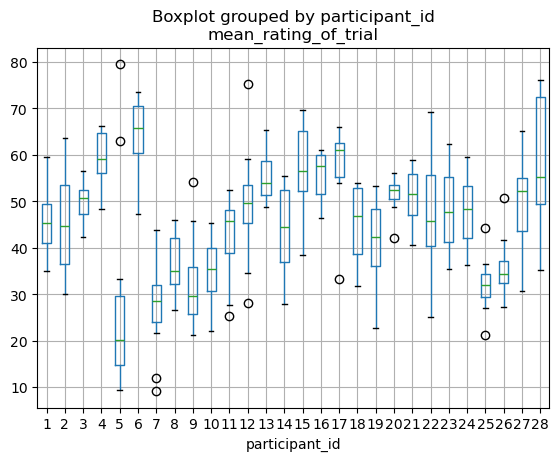

In [ ]:
query = """
SELECT mean(rating) AS mean_rating_of_trial, trial_id, participant_id
FROM raw_stimulus
GROUP BY trial_id, participant_id, trial_id
ORDER BY participant_id, trial_id;
;
"""
with db:
    df = db.execute(query).pl()
df.to_pandas().boxplot(  # boxplots look better in pandas
    column="mean_rating_of_trial", by="participant_id"
);

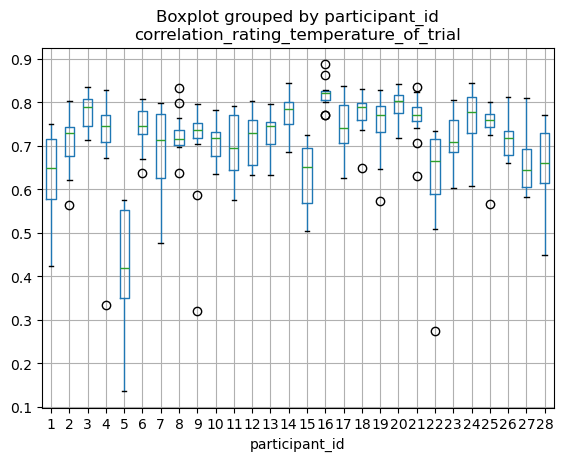

In [ ]:
query = """
SELECT corr(rating, temperature) AS correlation_rating_temperature_of_trial, trial_id, participant_id
FROM raw_stimulus
GROUP BY trial_id, participant_id, trial_id
ORDER BY correlation_rating_temperature_of_trial DESC
;
"""
with db:
    df = db.execute(query).pl()
df.to_pandas().boxplot(
    column="correlation_rating_temperature_of_trial", by="participant_id"
);

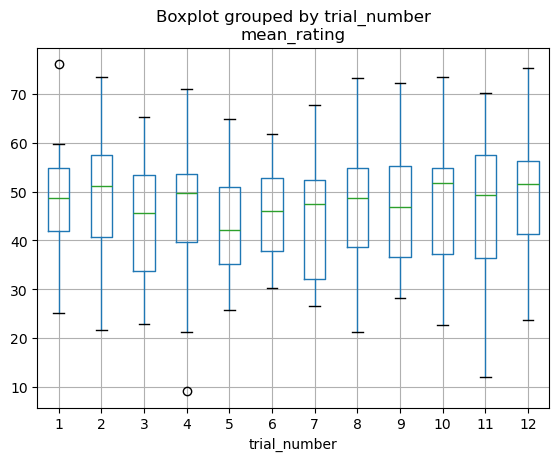

In [ ]:
query = """
SELECT mean(rating) AS mean_rating, trial_id, trial_number, participant_id
FROM raw_stimulus
WHERE NOT participant_id = 5
GROUP BY trial_id, participant_id, trial_id, trial_number
ORDER BY mean_rating DESC
;
"""
with db:
    df = db.execute(query).pl()
df.to_pandas().boxplot(column="mean_rating", by="trial_number");

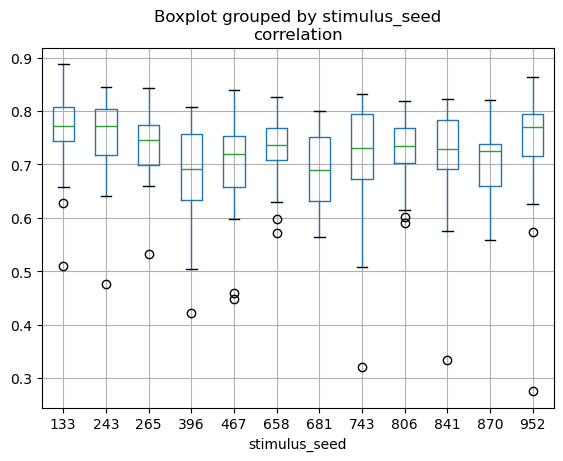

In [ ]:
query = """
SELECT
    trial_id,
    s.trial_number,
    s.participant_id,
    stimulus_seed,
    skin_area,
    corr(rating, temperature) as correlation
FROM raw_stimulus as s
-- get the seeds from trials
JOIN trials as t USING (trial_id)
WHERE NOT s.participant_id = 5
GROUP BY s.trial_id, s.participant_id, s.trial_number, stimulus_seed, skin_area
ORDER BY s.participant_id, trial_id
"""

with db:
    df = db.execute(query).pl()
df.to_pandas().boxplot(column="correlation", by="stimulus_seed");

# TODO:

Exclude participants and trials from data, e. g.:

```sql
query = """
SELECT
    trial_id,
    s.trial_number,
    s.participant_id,
    stimulus_seed,
    skin_area,
    corr(rating, temperature) as correlation
FROM raw_stimulus as s
-- get the seeds from trials
JOIN trials as t USING (trial_id)
WHERE s.participant_id % 2 = 1
WHERE NOT s.participant_id IN (SELECT participant_id FROM participants WHERE excluded)
WHERE NOT s.trial_id IN (SELECT trial_id FROM trials WHERE excluded)
GROUP BY s.trial_id, s.participant_id, s.trial_number, stimulus_seed, skin_area
ORDER BY s.participant_id, trial_id
"""
```

In [4]:
query = """
WITH stats AS (
  SELECT participant_id,
         MIN(temperature) AS min_temp,
         MAX(temperature) AS max_temp
  FROM raw_stimulus
  GROUP BY participant_id
),
normalized_timestamps AS (
  SELECT *,
         timestamp - MIN(timestamp) OVER (PARTITION BY trial_id) AS normalized_timestamp
  FROM raw_stimulus
)
SELECT n.*,
       n.rating / 100.0 AS normalized_rating,
       (n.temperature - s.min_temp) / NULLIF(s.max_temp - s.min_temp, 0) AS normalized_temperature,
       t.stimulus_seed,
       n.normalized_timestamp
FROM normalized_timestamps n
JOIN stats s ON n.participant_id = s.participant_id
JOIN trials t ON n.trial_id = t.trial_id
ORDER BY n.trial_id
;
"""

with db:
    df = db.execute(query).pl()
df

trial_id,trial_number,participant_id,rownumber,timestamp,temperature,rating,normalized_timestamp,normalized_rating,normalized_temperature,stimulus_seed
u16,u8,u8,u32,f64,f64,f64,f64,f64,f64,u16
1,1,1,0,294224.331,45.75,42.5,0.0,0.425,0.0,396
1,1,1,1,294357.9645,45.750102,42.5,133.6335,0.425,0.000068,396
1,1,1,2,294458.0292,45.75041,35.375,233.6982,0.35375,0.000273,396
1,1,1,3,294558.6006,45.750922,14.875,334.2696,0.14875,0.000615,396
1,1,1,4,294658.3354,45.751639,10.125,434.0044,0.10125,0.001093,396
1,1,1,5,294758.4957,45.75256,22.75,534.1647,0.2275,0.001707,396
…,…,…,…,…,…,…,…,…,…,…
332,12,28,21606,2.7766e6,45.587356,85.0,179498.3054,0.85,0.15829,133
332,12,28,21607,2.7767e6,45.585285,85.0,179600.0331,0.85,0.156909,133


In [5]:
df = prepare_multiline_hvplot(df, "normalized_timestamp")

In [6]:
df.hvplot(
    x="normalized_timestamp",
    y=["normalized_rating", "normalized_temperature"],
    ylim=(0, 1),
    groupby=["trial_number", "participant_id"],
    kind="line",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'a3beaddf-6c8c-4e9b-b9db-51d39add511b': {'version…

In [7]:
# result_df = add_nan_to_trials(df)
df.plot(
    x="normalized_timestamp",
    y=["normalized_rating", "normalized_temperature"],
    ylim=(0, 1),
    groupby=["stimulus_seed"],
    kind="line",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'45b70d9c-af01-40ce-8256-ef98656543d7': {'version…

In [10]:
query = """
WITH binned_data AS (
  SELECT 
    stimulus_seed,
    FLOOR(normalized_timestamp / 1000) * 1000 AS time_bin,  -- 1 second bins
    AVG(normalized_rating) AS avg_rating,
    AVG(normalized_temperature) AS avg_temperature,
    COUNT(*) AS sample_size,
    STDDEV_SAMP(normalized_rating) AS std_dev
  FROM normalized_stimulus
  GROUP BY stimulus_seed, time_bin
)
SELECT 
  stimulus_seed,
  time_bin,
  avg_rating,
  avg_rating - 1.96 * (std_dev / SQRT(sample_size)) AS ci_lower,
  avg_rating + 1.96 * (std_dev / SQRT(sample_size)) AS ci_upper,
  avg_temperature
FROM binned_data
ORDER BY stimulus_seed, time_bin;
"""

with db:
    df = db.execute(query).pl()
df = prepare_multiline_hvplot(df, "time_bin", "stimulus_seed")
df.plot(
    x="time_bin",
    y=["avg_rating", "avg_temperature"],
    groupby="stimulus_seed",
    kind="line",
    grid=True,
) * df.hvplot.area(
    x="time_bin",
    y="ci_lower",
    y2="ci_upper",
    groupby="stimulus_seed",
    alpha=0.5,
    line_width=0,
    fill_color="lightblue",
    grid=True,
    ylim=(0, 1),
    xlim=(0, 180 * 1000),
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'e872c4ca-e6de-4fb5-a6d1-7d9862359bbf': {'version…

In [11]:
# # correlation between temperature and rating
# df.group_by("stimulus_seed").agg(
#     [pl.corr("avg_rating", "avg_temperature").alias("correlation")]
# ).sort("correlation", descending=True)

stimulus_seed,correlation
u16,f64
133,NaN
243,NaN
265,NaN
396,NaN
467,NaN
658,NaN
681,NaN
743,NaN
806,NaN
